# Climate Analysis

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Precipitation score')

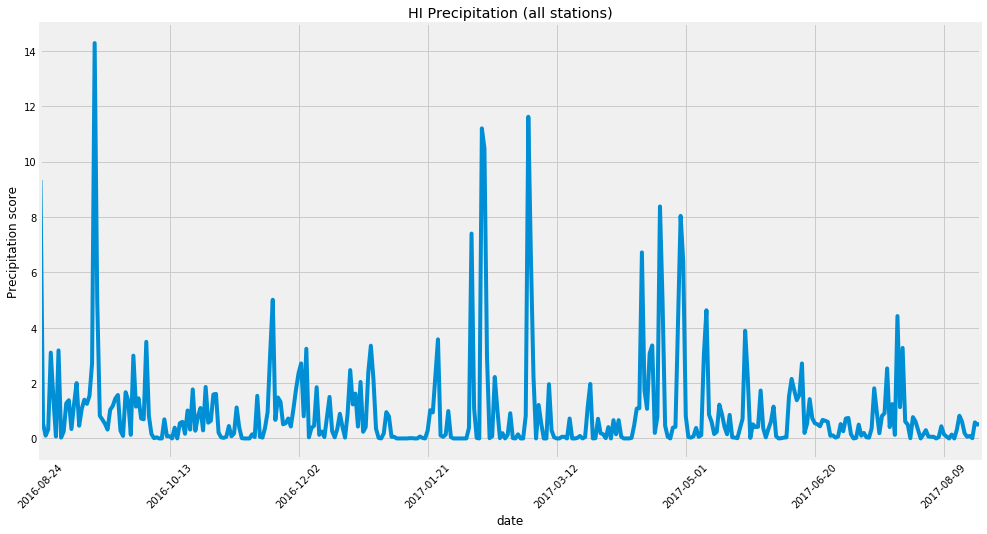

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.datetime.strptime(last_date[0], "%Y-%m-%d")
query_date = year_ago - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_date = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_date)
prcp_df = prcp_df.dropna(how='any')

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date')
prcp_df = prcp_df.groupby('date').sum()

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.line(figsize=(15,8), legend=False, title='HI Precipitation (all stations)')
plt.xticks(rotation=45)
plt.ylabel('Precipitation score')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
avg_prcp = prcp_df['prcp'].mean()
med_prcp = prcp_df['prcp'].median()
min_prcp = prcp_df['prcp'].min()
max_prcp = prcp_df['prcp'].max()
total_rain = prcp_df['prcp'].sum()

print(f'Average daily precipitation: {round(avg_prcp,2)}')
print(f'Median daily precipitation: {round(med_prcp,2)}')
print(f'Min daily precipitation: {round(min_prcp,2)}')
print(f'Max daily precipitation: {round(max_prcp,2)}')
print(f'Total yearly precipitation: {round(total_rain,2)}')

Average daily precipitation: 0.97
Median daily precipitation: 0.4
Min daily precipitation: 0.0
Max daily precipitation: 14.28
Total yearly precipitation: 355.57


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
station_count

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_data = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = station_data[0][0]

min_temp = session.query(Measurement.tobs).\
    filter(Measurement.station==most_active).\
    order_by(Measurement.tobs).first()

max_temp = session.query(Measurement.tobs).\
    filter(Measurement.station==most_active).\
    order_by(Measurement.tobs.desc()).first()

mean_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station==most_active).all()

print(f'The min temp at {most_active} was {min_temp[0]}°')
print(f'The max temp at {most_active} was {max_temp[0]}°')
print(f'The average temp at {most_active} was {round(mean_temp[0][0],2)}°')

The min temp at USC00519281 was 54.0°
The max temp at USC00519281 was 85.0°
The average temp at USC00519281 was 71.66°


Text(0, 0.5, 'Records')

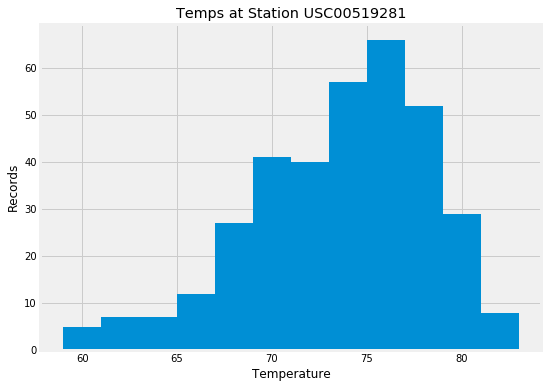

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the temperature scores
station_temp = session.query(Measurement.tobs).\
    filter(Measurement.date > query_date).\
    filter(Measurement.station == most_active).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(station_temp)
temp_df = temp_df.dropna(how='any')

# Use Pandas Plotting with Matplotlib to plot the data
temp_df.plot.hist('tobs', bins=12, figsize=(8,6), title=(f'Temps at Station {most_active}'), legend=False)
plt.xlabel('Temperature')
plt.ylabel('Records')


## Step 2 - Climate App

Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

* Use Flask to create your routes.

### Routes

* `/`

  * Home page.

  * List all routes that are available.

* `/api/v1.0/precipitation`

  * Convert the query results to a dictionary using `date` as the key and `prcp` as the value.

  * Return the JSON representation of your dictionary.

* `/api/v1.0/stations`

  * Return a JSON list of stations from the dataset.

* `/api/v1.0/tobs`
  * Query the dates and temperature observations of the most active station for the last year of data.
  
  * Return a JSON list of temperature observations (TOBS) for the previous year.

* `/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

  * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

  * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

  * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

## Hints

* You will need to join the station and measurement tables for some of the queries.

* Use Flask `jsonify` to convert your API data into a valid JSON response object.

- - -

## Bonus: Other Recommended Analyses

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

### Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

* You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

### Temperature Analysis II

* The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d`. The function will return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).

### Daily Rainfall Average

* Calculate the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

* You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic TOBS that match that date string.

* Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

* Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
